In [2]:
# Import needed modules

import alias

import numpy as np
import pandas
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits

import scipy.stats
import scipy.signal

import random as rand

# Inline plots
%matplotlib inline

In [4]:
# Read fits files

#with open('../data/sample_star_urls_rev2', 'r') as f:
#    urls = f.read().splitlines()

files = [ '../data/spectra_rev2/%s' %url.split('/')[-1] for url in urls ]

ds = alias.loadDataset(files)

NameError: name 'urls' is not defined

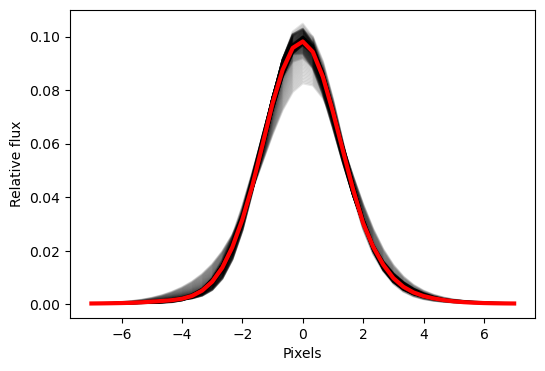

In [6]:
# Load and compute median LSF

plt.figure(figsize=(6,4))

file = '../data/apogee-lsf-dr12-all.fits'
hdul = fits.open(file)
data = hdul[0].data
x = np.linspace(-7.,7.,43)
for k in range(0,data.shape[0],100):
    plt.plot(x, data[k,:], c='k', alpha=0.1)
    
med = np.nanmedian(data, axis=0)


plt.plot(x, med, c='r', lw=3)

plt.xlabel('Pixels')
plt.ylabel('Relative flux')

lsfx = x
lsfy = med/np.max(med)


In [4]:
# Code for injecting a LASER technosignature into a spectrum
# Note: Now moved to alias.injection

def inject_line(wave, flux, lsfx, lsfy, wl, amp):
    # Get fractional index in wave array where line should be
    idx = np.interp(wl, wave, range(len(wave)))
    # Resample LSF
    line = np.interp(np.array(range(len(wave)))-idx, lsfx, lsfy)
    # Add line to original flux
    return flux + line*amp, idx

In [10]:
# Running some statistical tests to guage the effectiveness of scipy's 
# peak characterization in identifying weak LASER signatures.

wlen = None
rel_h = 0.1

n = 11 #rand.randrange(len(allFlux))


peaks = np.nonzero(~np.isnan(ds.flux[n]))[0]

prom = scipy.signal.peak_prominences(ds.flux[n], peaks, wlen=wlen)[0]
width = scipy.signal.peak_widths(ds.flux[n], peaks, wlen=wlen, rel_height=rel_h)[0]


prom_inject = []
width_inject = []

for i in peaks:
    test_line, idx = inject_line(ds.wave, ds.flux[n], lsfx, lsfy, ds.wave[i] + np.random.uniform(-0.5,0.5), 0.05)
    prom_inject.append(scipy.signal.peak_prominences(test_line, [int(np.rint(idx))], wlen=wlen)[0][0])
    width_inject.append(scipy.signal.peak_widths(test_line, [int(np.rint(idx))], wlen=wlen, rel_height=rel_h)[0][0])

prom_inject = np.array(prom_inject)
width_inject = np.array(width_inject)

/tmp/ipykernel_902705/2225862949.py:12: PeakPropertyWarning: some peaks have a prominence of 0
  prom = scipy.signal.peak_prominences(ds.flux[n], peaks, wlen=wlen)[0]
/tmp/ipykernel_902705/2225862949.py:13: PeakPropertyWarning: some peaks have a prominence of 0
  width = scipy.signal.peak_widths(ds.flux[n], peaks, wlen=wlen, rel_height=rel_h)[0]
/tmp/ipykernel_902705/2225862949.py:13: PeakPropertyWarning: some peaks have a width of 0
  width = scipy.signal.peak_widths(ds.flux[n], peaks, wlen=wlen, rel_height=rel_h)[0]
/tmp/ipykernel_902705/2225862949.py:21: PeakPropertyWarning: some peaks have a prominence of 0
  prom_inject.append(scipy.signal.peak_prominences(test_line, [int(np.rint(idx))], wlen=wlen)[0][0])
/tmp/ipykernel_902705/2225862949.py:22: PeakPropertyWarning: some peaks have a prominence of 0
  width_inject.append(scipy.signal.peak_widths(test_line, [int(np.rint(idx))], wlen=wlen, rel_height=rel_h)[0][0])
/tmp/ipykernel_902705/2225862949.py:22: PeakPropertyWarning: some peak

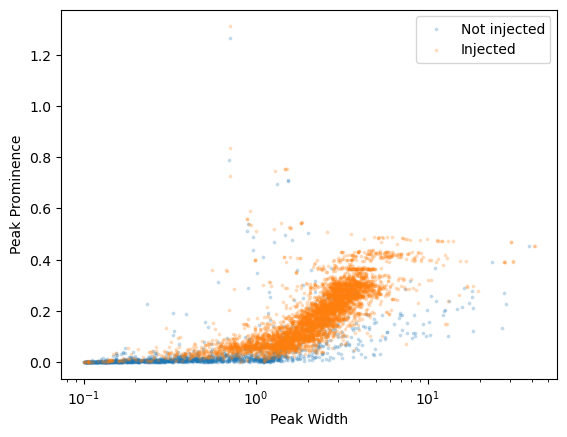

In [11]:
plt.scatter(width, prom, s=3, label='Not injected', alpha=0.2)
plt.scatter(width_inject, prom_inject, s=3, label='Injected', alpha=0.2)
plt.xlabel('Peak Width')
plt.ylabel('Peak Prominence')
plt.xscale('log')
plt.legend()

In [12]:
# Calculate number of successful detections.
sum(prom_inject > 0.05)

# Should be at least 8000

4506

In [13]:
# Calculate number of false positives
sum(prom > 0.05)

# Should be 0, or occasionally 1.

243

- Start with flat line
- Recover position and strength